In [2]:
import numpy as np
from metasense.data import load_board
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from nonconformist.cp import IcpRegressor
from nonconformist.nc import NcFactory
sns.set_style('white')

In [23]:
def train_classifier(cf, features, target):
    X, Y = X_train[features], X_train[target]
    X_, Y_ = X_test[features], X_test[target]
    cf.fit(X_train[features], X_train[target])
    Y_pred = cf.predict(X_)
    return cf, (mean_absolute_error(Y, cf.predict(X)), mean_absolute_error(Y_, Y_pred))
def plot_columns(cf, features, gas):
    cf, results = train_classifier(cf, features, "epa-%s" % gas)
    fig, ax = plt.subplots(2, figsize=(6, 4))
    plt.suptitle(gas)
    ax[0].set_title('Training Data')
    X_train['%s-pred' % gas] = cf.predict(X_train[features])
    X_train[['%s-pred' % gas, 'epa-%s'%gas]].plot(ax=ax[0], alpha=0.8)
    ax[1].set_title('Test Data')
    X_test['%s-pred' % gas] = cf.predict(X_test[features])
    X_test[['%s-pred' % gas, 'epa-%s'%gas]].plot(ax=ax[1], alpha=0.8)
    print("MAE:", *results)
    print("CvMAE", results[0] / X_train['epa-%s'%gas].mean(), results[1] / X_test['epa-%s'%gas].mean())
    plt.show()

# Donovan

### Board 17

MAE: 3.68587367515 3.52476482145
CvMAE 0.0985668248664 0.09391491885


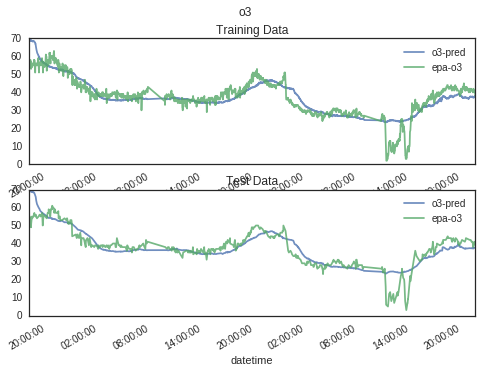

MAE: 2.30928279745 2.15607717022
CvMAE 0.551297896553 0.539726976528


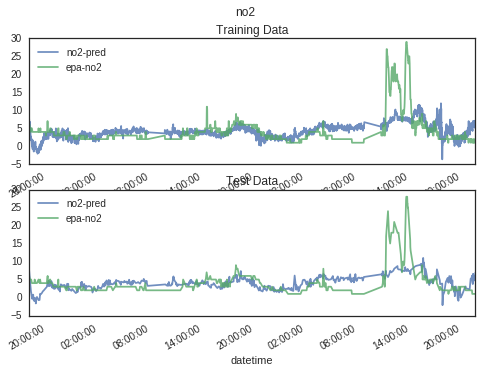

In [9]:
X_train, X_test = load_board('donovan17', sd=True)
plot_columns(LinearRegression(), ['o3', 'temperature', 'humidity'], 'o3')
plot_columns(LinearRegression(), ['o3', 'temperature', 'no2', 'humidity'], 'no2')

### Board 19

MAE: 3.96495001884 3.9261352088
CvMAE 0.10448021546 0.103764693328


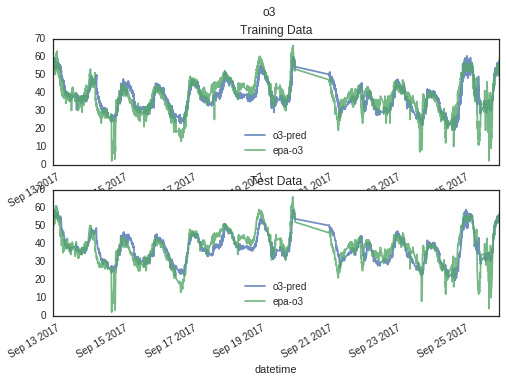

MAE: 2.96032202975 2.89894358753
CvMAE 0.700471809682 0.696185694884


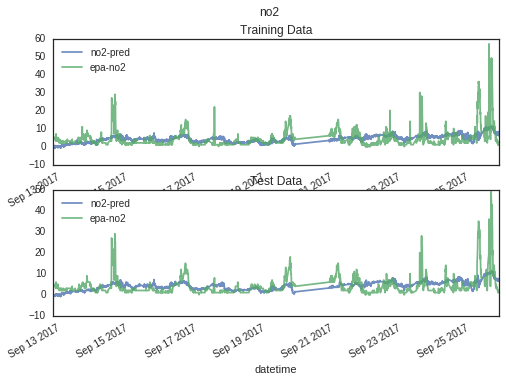

In [10]:
X_train, X_test = load_board('donovan19', sd=True)
plot_columns(LinearRegression(), ['o3', 'temperature', 'humidity'], 'o3')
plot_columns(LinearRegression(), ['o3', 'temperature', 'no2', 'humidity'], 'no2')

### Board 21

MAE: 4.44052554427 4.52034184361
CvMAE 0.117158655211 0.118872484502


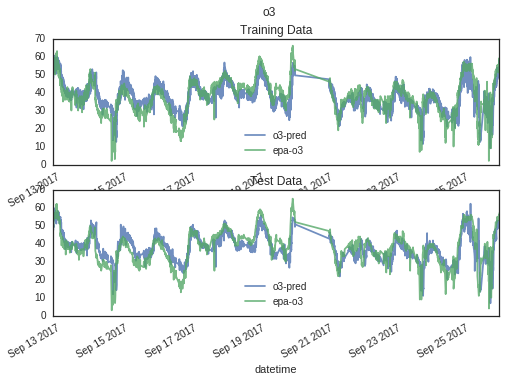

MAE: 2.89630802617 2.86566390068
CvMAE 0.68773756127 0.678529620942


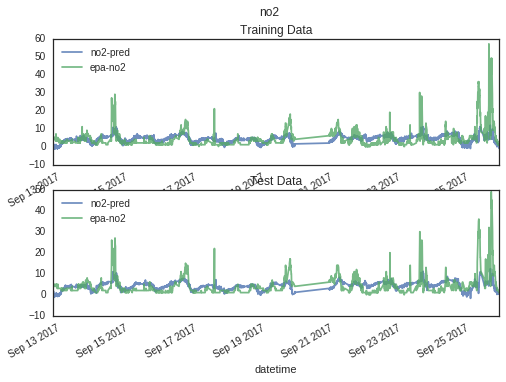

In [13]:
X_train, X_test = load_board('donovan21', sd=True)
plot_columns(LinearRegression(), ['o3', 'no2'], 'o3')
plot_columns(LinearRegression(), ['o3', 'no2'], 'no2')

# El Cajon

### Board 11

MAE: 41.5132994753 42.0987180678
CvMAE 0.196783425811 0.200818359713


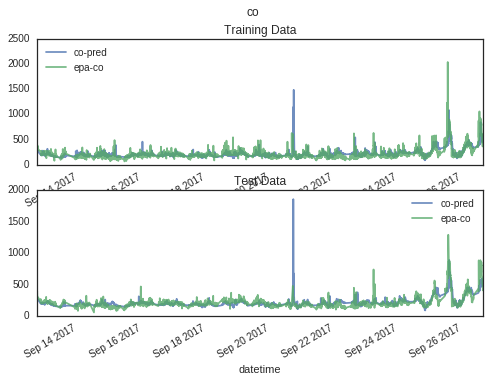

MAE: 5.99175052683 6.00247955816
CvMAE 0.158241087292 0.159011103524


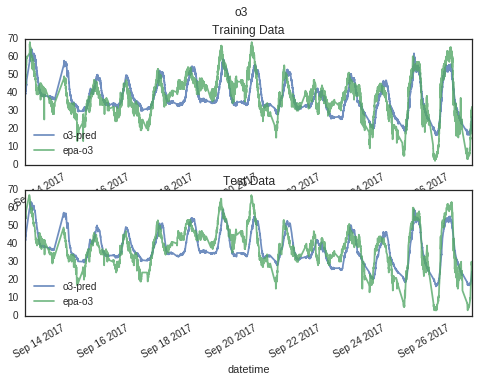

MAE: 2.43462300622 2.43376982772
CvMAE 0.451558113199 0.458253374134


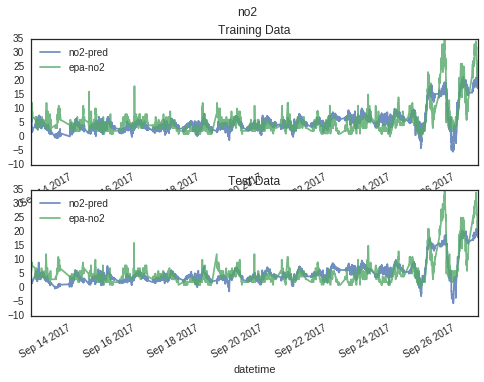

In [14]:
X_train, X_test = load_board('elcajon11', sd=True)
plot_columns(LinearRegression(), ['co', 'temperature', 'humidity'], 'co')
plot_columns(LinearRegression(), ['o3', 'temperature', 'humidity'], 'o3')
plot_columns(LinearRegression(), ['no2', 'temperature', 'humidity'], 'no2')

### Board 12

MAE: 46.5541824969 46.8302280718
CvMAE 0.220877129457 0.2225827471


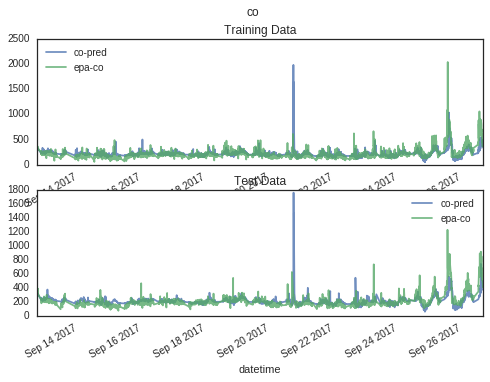

MAE: 5.76107050338 5.74703808558
CvMAE 0.152480528426 0.150927175082


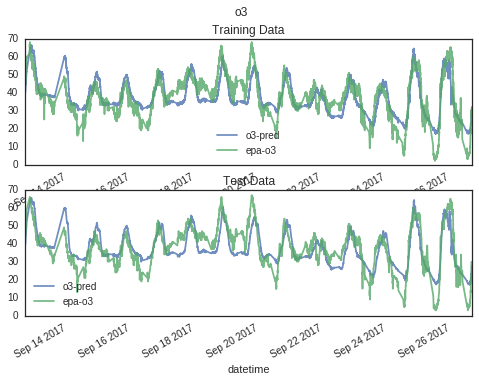

In [8]:
X_train, X_test = load_board('elcajon12', sd=True)
plot_columns(LinearRegression(), ['co'], 'co')
plot_columns(LinearRegression(), ['o3', 'temperature','humidity'], 'o3')

### Board 13

MAE: 45.6131484937 44.9281805156
CvMAE 0.216180644817 0.214463501322


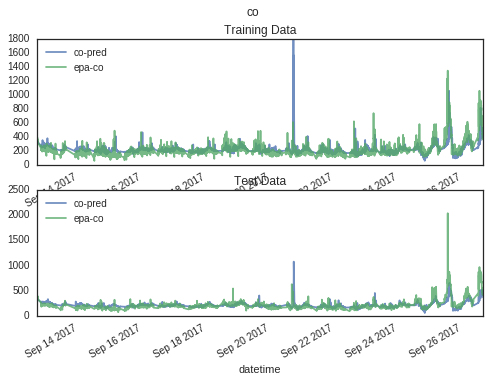

MAE: 5.76018184047 5.83565865779
CvMAE 0.152473690419 0.153187988104


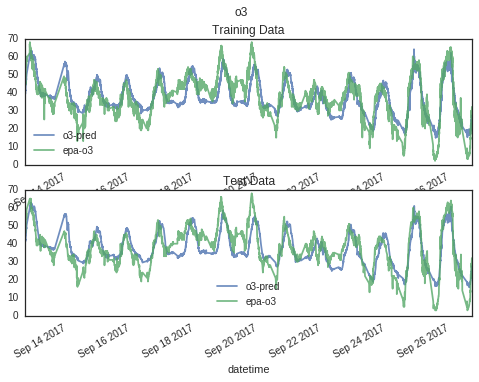

In [7]:
X_train, X_test = load_board('elcajon13', sd=True)
plot_columns(LinearRegression(), ['co'], 'co')
plot_columns(LinearRegression(), ['o3', 'temperature','humidity'], 'o3')

# Random Forest

MAE: 7.76923254366 22.1323556015
CvMAE 0.0369404353484 0.104298742229


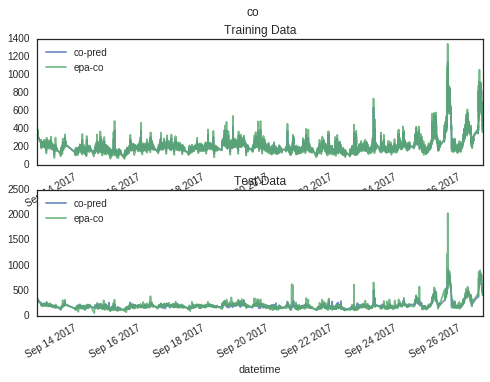

MAE: 0.697129051064 1.78707514573
CvMAE 0.018439434051 0.0470507340404


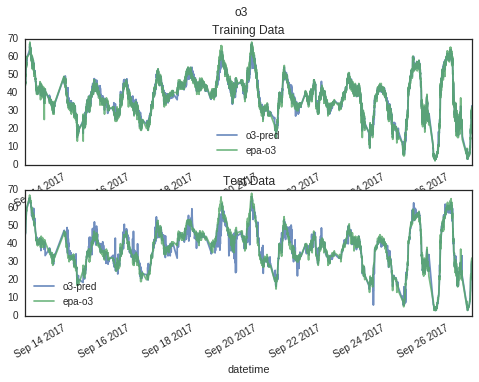

MAE: 0.261525496008 0.717738738739
CvMAE 0.0486423269549 0.133622703684


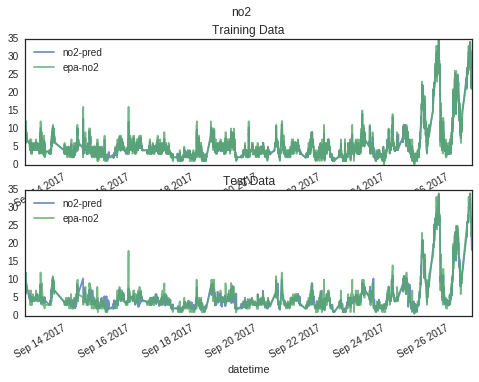

In [15]:
X_train, X_test = load_board('elcajon13', sd=True)
plot_columns(RandomForestRegressor(200), ['co', 'temperature', 'humidity'], 'co')
plot_columns(RandomForestRegressor(200), ['o3', 'temperature', 'humidity'], 'o3')
plot_columns(RandomForestRegressor(200), ['o3', 'temperature', 'no2', 'humidity'], 'no2')

MAE: 0.98387227918 2.72825504732
CvMAE 0.0259155250098 0.0722224694987


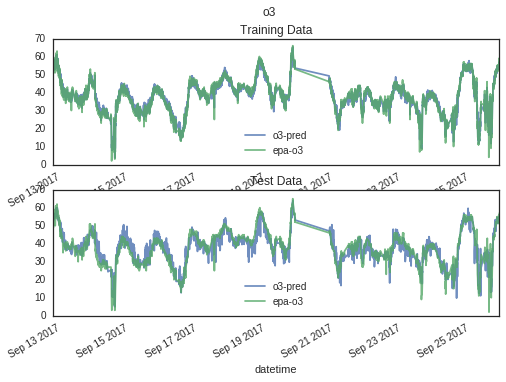

MAE: 0.315651419558 0.864752365931
CvMAE 0.0750156498922 0.204069455818


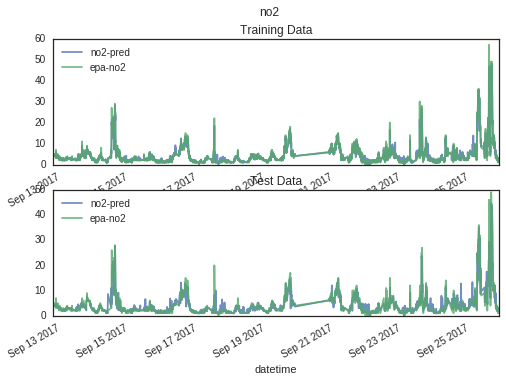

In [10]:
X_train, X_test = load_board('donovan21', sd=True)
plot_columns(RandomForestRegressor(200), ['o3', 'temperature', 'no2'], 'o3')
plot_columns(RandomForestRegressor(200), ['o3', 'temperature', 'no2', 'humidity'], 'no2')

# Intervals

In [29]:
model = LinearRegression()
def train_classifier(cf, features, target):
    cf = IcpRegressor(NcFactory.create_nc(cf))
    X, Y = X_train[features], X_train[target]
    X, X_valid, Y, y_valid = train_test_split(X, Y)
    X_, Y_ = X_test[features], X_test[target]
    cf.fit(X.as_matrix(), Y.as_matrix())
    cf.calibrate(X_valid.as_matrix(), y_valid.as_matrix())
    #Y_pred = cf.predict(X_.as_matrix(), significance=0.05)
    return cf
def plot_columns(cf, features, gas, confidence=0.95):
    cf  = train_classifier(cf, features, "epa-%s" % gas)
    train_results = cf.predict(X_train[features].as_matrix(), significance=1 - confidence)
    test_results = cf.predict(X_test[features].as_matrix(), significance=1 - confidence)

    X_train['lower-%s'%gas], X_train['upper-%s'%gas] = train_results[:, 0], train_results[:, 1]
    X_test['lower-%s'%gas], X_test['upper-%s'%gas] = test_results[:, 0], test_results[:, 1]
    X_train['%s-in-interval'%gas] = (X_train['lower-%s'%gas] <= X_train['epa-%s'%gas]) & (X_train['epa-%s'%gas] <= X_train['upper-%s'%gas])
    X_test['%s-in-interval'%gas] = (X_test['lower-%s'%gas] <= X_test['epa-%s'%gas]) & (X_test['epa-%s'%gas] <= X_test['upper-%s'%gas])
    print("Width:", (X_train['upper-%s'%gas] - X_train['lower-%s'%gas]).mean(),(X_test['upper-%s'%gas] - X_test['lower-%s'%gas]).mean())
    print("Accuracy:", X_train['%s-in-interval'%gas].mean(), X_test['%s-in-interval'%gas].mean())
    fig, ax = plt.subplots(2, figsize=(10, 8))
    plt.suptitle(gas)
    ax[0].set_title('Training Data')
    ax[0].fill_between(X_train.index.values, X_train['lower-%s'%gas], X_train['upper-%s'%gas], alpha=0.4)
    X_train['epa-%s'%gas].plot(ax=ax[0], alpha=0.8)
    ax[1].set_title('Test Data')
    X_test['epa-%s'%gas].plot(ax=ax[1], alpha=0.8)
    ax[1].fill_between(X_test.index.values, X_test['lower-%s'%gas], X_test['upper-%s'%gas], alpha=0.4)
    plt.show()


Width: 240.648808729 240.648808729
Accuracy: 0.94967803482 0.940222575517


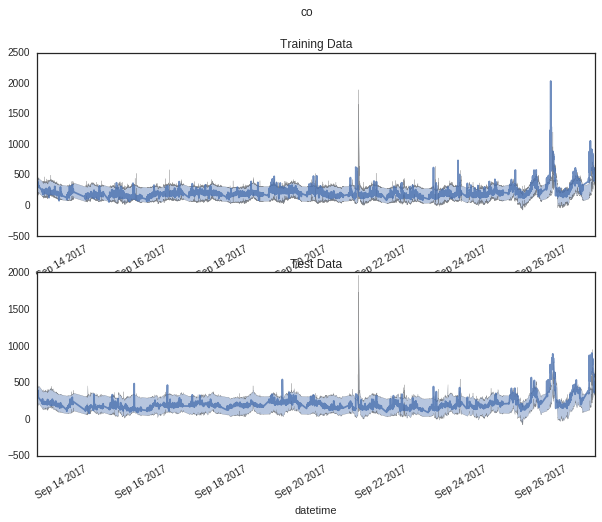

Width: 26.8951549571 26.8951549571
Accuracy: 0.947372605136 0.941176470588


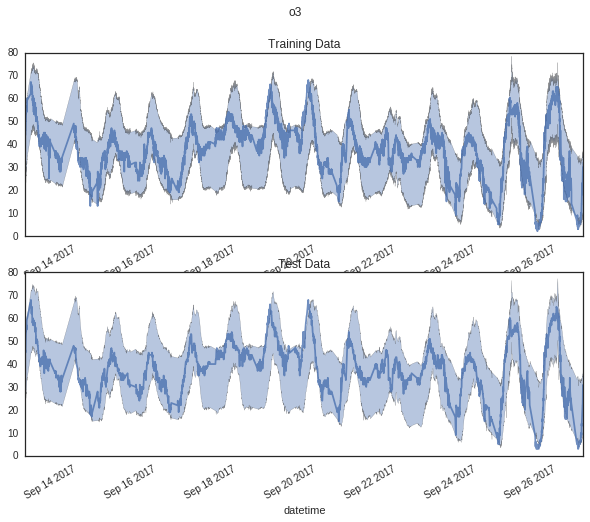

Width: 13.4574515623 13.4574515623
Accuracy: 0.94967803482 0.941494435612


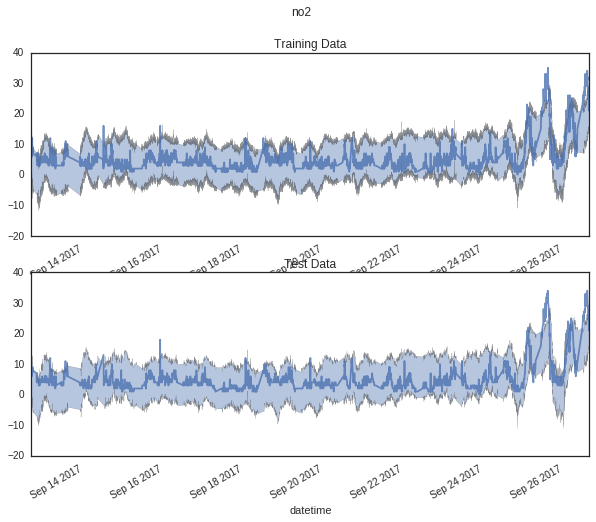

In [30]:
X_train, X_test = load_board('elcajon13', sd=True)
plot_columns(LinearRegression(), ['co'], 'co', confidence=0.95)
plot_columns(LinearRegression(), ['o3', 'temperature'], 'o3')
plot_columns(LinearRegression(), ['o3', 'temperature', 'humidity', 'no2'], 'no2')

Width: 293.551 293.551
Accuracy: 0.981238572224 0.949125596184


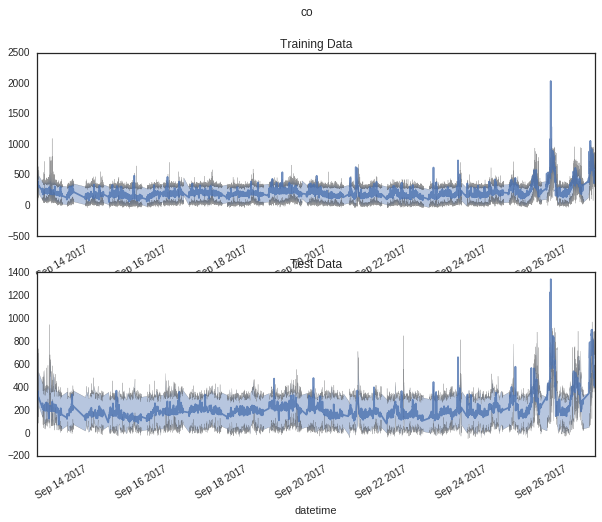

Width: 10.38 10.38
Accuracy: 0.98656490977 0.94626391097


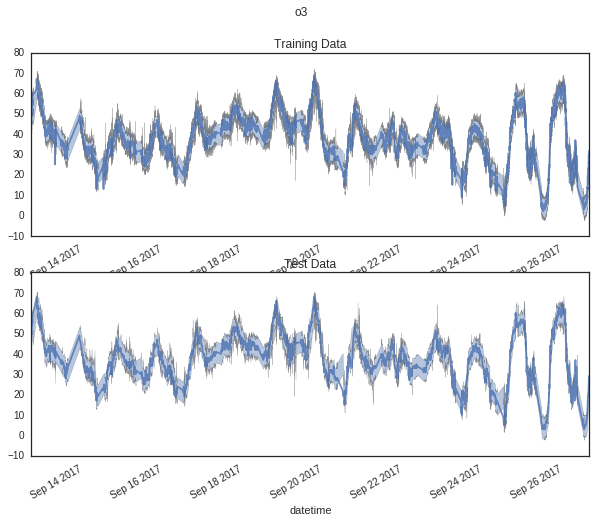

Width: 4.91 4.91
Accuracy: 0.986087924318 0.956438791733


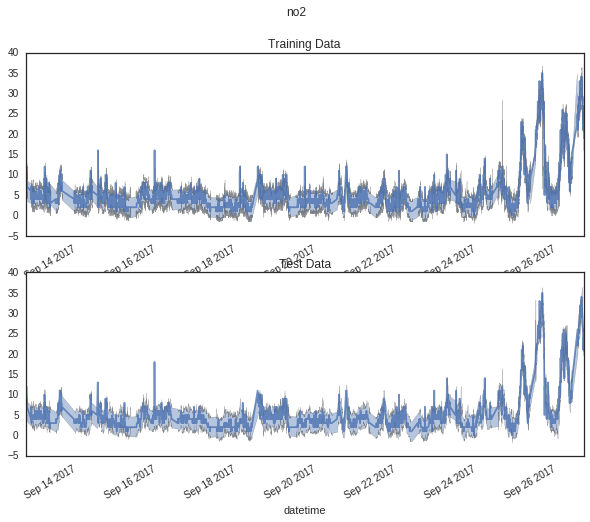

In [31]:
X_train, X_test = load_board('elcajon13', sd=True)
plot_columns(RandomForestRegressor(200), ['co'], 'co')
plot_columns(RandomForestRegressor(200), ['o3', 'temperature', 'humidity','no2'], 'o3')
plot_columns(RandomForestRegressor(200), ['o3', 'temperature', 'humidity', 'no2'], 'no2')

Width: 22.0236011024 22.0236011024
Accuracy: 0.953627760252 0.957097791798


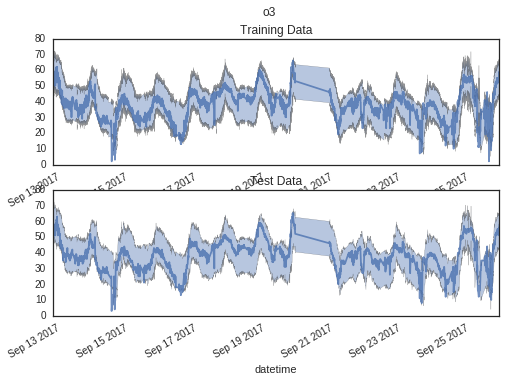

Width: 12.1623199463 12.1623199463
Accuracy: 0.947160883281 0.943217665615


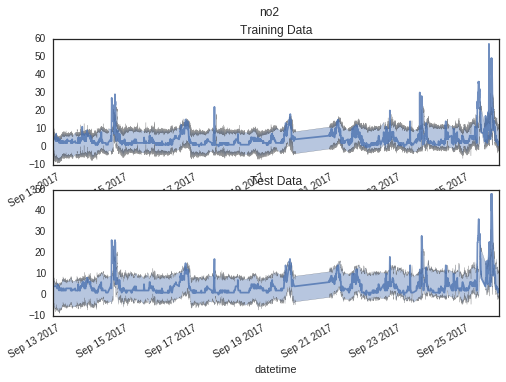

In [14]:
X_train, X_test = load_board('donovan21', sd=True)
plot_columns(LinearRegression(), ['o3', 'temperature', 'no2'], 'o3')
plot_columns(LinearRegression(), ['o3', 'temperature', 'no2', 'humidity'], 'no2')

Width: 16.33 16.33
Accuracy: 0.986593059937 0.956466876972


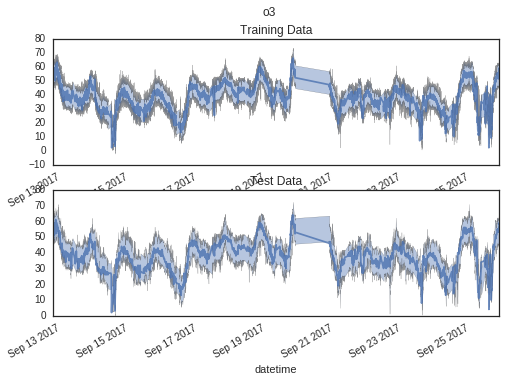

Width: 7.15 7.15
Accuracy: 0.982018927445 0.953312302839


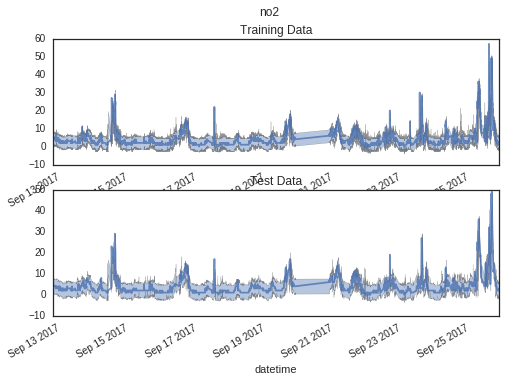

In [15]:
X_train, X_test = load_board('donovan21', sd=True)
plot_columns(RandomForestRegressor(200), ['o3', 'temperature', 'no2'], 'o3')
plot_columns(RandomForestRegressor(200), ['o3', 'temperature', 'no2', 'humidity'], 'no2')